## Forest Fire -  Model of self-organized criticality

to understand self-organized criticality let's break it down a bit: 

**What is a critical point? **<br>
A critical point is when a system nears a point where it can transition states. The best example is the water/vapor critical point that you observe when you're heating water for your spaghetti. Note that there's no point at which your water suddenly evaporates but rather for some time both states coexist due to the boiling point being a function of *spatial* (aka more than one) attributes. In this case not only temperature but also pressure. Formally, the critical point is desribed as "nearing the end point of a phase equilibrium curve". 

**Power Law ** <br>
Following the power law the probability of an event is inversely related to its size. High magnitude events happen very infrequently. The larger, the less likely it occurs. Think book sales by author, eartquakes or wealth. Because  very large events happen very infrequently (often much less than we could even observe in our lifetime) we tend to get surprised by them (see Black Swan). 

**Power Laws in nature** <br>
We can observe many power laws in nature: of course earthquakes (The Gutenberg-Richter scale itself the logarithm of earthquake magnitudes: An earthquake measuring 6 is 10x as large as a 5), animal-metabolism to size, variance of population sizes, neuronal avalanches and many more. 

**the critical point & power law** <br>
I brought up the critical point before because in nature we sometimes observe a system moving to one where its effect size starts behaving like a power law. Bak, Tang & Wiesenfelds seminal paper on this gave the example of a sandpile. Imagine someone dropping grains of sand onto a table from half a meter above, akin to a giant hourglass. As the grains accumulate, a growing pile forms. Eventually, the grains reach a critical state where an additional grain of sand can cause an avalanche that brings down other grains with it. They found that at this critical state, the number of grains toppling follows a power-law distribution. Many small ones with the occasional mega-avalanche. 

**nature vs nurture, or self-organized vs tuned**<br>
When we cook our spaghetti we heat the water and aim to bring the liquid to the critical state. Physicists would say we "tune" a variable to get there. But here's the kicker. Bak, Tang & Wiesenfeld showed that their sandpile naturally tends toward a critical state and remains there **without tuning**. It **self-organizes** towards a state where effect sizes follow a power-law distribution.<br> 
I think the sand-pile model is great for the intution of one grain being able to have vastly different outcomes (often none, sometimes a huge avalanche). However, the forest-fire model really brings the point of self-organizing home. 


In [48]:
import random
import numpy as np
import pprint
import copy
import matplotlib.pyplot as plt
import time
from IPython.display import HTML
from collections import Counter
%matplotlib inline

def create_grid(size = 10, cell=0):
    grid = []
    for x in range(0,size):
        grid.append([cell]*size)
    return grid

def chance(p=0.8):
    "returns 1 following given probability"
    number = random.random()
    if number <= p:
        return 1 
    return 0

def is_tree(x,y,grid):
    #out of range
    if x < 0 or y < 0:
        return 0
    try:
        if grid[x][y] == 1:
            return 1
    #out of range 2
    except IndexError:
        return 0    
    return 0

def light_up_coordinates(x,y, grid):
    "helper function"
    copied_list = copy.deepcopy(grid)
    copied_list[x][y] = '$'
    for x in copied_list:
        print(x)
        
def make_turn(x,y, grid, prob=0.8, population=0):
    if is_tree(x,y, grid):
        if chance(p=1-prob): 
            # tree burns
            burned = burn_trees_faster(x,y, grid)
            population -= burned
    else:
        if chance(p=prob):
            # tree grows
            population += 1
            grid[x][y] = 1
    return population

def return_all_neighbors(x,y, grid):
    trees_to_check = []
    #all neighbors
    for n_x,n_y in [(x-1,y+1),(x, y+1),(x+1,y+1),(x+1, y),(x+1,y-1),(x,y-1),(x-1,y-1),(x-1,y)]:
        if is_tree(n_x,n_y, grid):
            trees_to_check.append((n_x,n_y))
    return trees_to_check

def burn_trees(root_x, root_y, grid):
    "burns tree and all neighbors"
    trees = [(root_x,root_y)]
    #obtaining the patch of neighboring trees
    for x,y in trees:
        new_trees = []
        new_trees += return_all_neighbors(x,y, grid)
        # this check is inefficient as it's almost tree_neighbors^2 complexity. The set implementation below is much faster
        for n_x, n_y in new_trees:
            if (n_x,n_y) not in trees:
                trees.append((n_x,n_y))
    #burning them all
    for x,y in trees:
        grid[x][y] = 0
    return len(trees)

def burn_trees_faster(root_x, root_y, grid):
    "burns tree and all neighbors"
    trees = set()
    trees.add((root_x,root_y))
    trees_burned = 0
    while True:
        if trees == set():
            return trees_burned
        trees_burned += 1
        tree = trees.pop()
        #burning the trees
        grid[tree[0]][tree[1]] = 0
        neighboring_trees = return_all_neighbors(tree[0],tree[1], grid)
        for neighbor in neighboring_trees:
            trees.add(neighbor)
            
def simulate_forest(grid_size=10, t=200, trials=100, prob=0.8, return_population_list=False):
    """simulates forest over t time-periods, with probability being that of tree-growth each t, 
    and 1-prob that of lightning each t. 
    The resulting forest population is averaged over the number of trials
    """
    populations = list()
    for run in range(trials):
        grid = create_grid(grid_size)
        population = 0
        population_development = list()
        for x in range(t):
            population_development.append(population)
            population = make_turn(random.randint(0,grid_size-1),random.randint(0,grid_size-1), grid, population=population, prob=prob)
        populations.append(population_development)
    
    if return_population_list:
        return populations
    # averaging over number of trials
    np_populations = np.array(populations)
    average = np_populations.mean(axis=0)
    std = np_populations.std(axis=0)
    return prob, average, std

def get_fire_sizes(population):
    """quick in dirty function to return the size of the fires that occur"""
    fire_sizes = list()
    
    for index, _ in enumerate(population):
        one = population[index]
        try:
            two = population[index+1]
        
            if two-one <0: 
                fire_sizes.append(abs(two-one))
        except IndexError:
            pass
    
    return fire_sizes

def plot_forest(simulation):
    prob, y, error = simulation
    x = range(len(y))
    plt.fill_between(range(len(y)), y-error/2, y+error/2, alpha=0.5)
    plt.plot(y,'-', label='probability of lightning: {}'.format(1-prob))
    plt.xlabel('time')
    plt.ylabel('size of forest')

### the forest fire model
The forest fire model assumes a two-dimensional grid on which trees can grow. Trees can also get hit by random lightning strikes which results in the tree and all connected neighbors burning. 
In a *sparse* forest any fires will be small. With increasing density a fire started can spread across much of the grid.

**formal definition:** 
The model assumes an empty *N by N* grid. Each period a random site on the grid is chosen. If empty, with probability g the site grows a tree. If the site contains a tree, with probability (1-g) lightning hits the site. If the site contains a tree, the tree catches fire, and the fire spreads to all connected sites with trees. Source: The Model Thinker, a fantastic book by Scott Page. 

for example this is a forest on a `100*100` grid with probability of lightning = `0.2` and probability of tree-growth = `0.8`. 

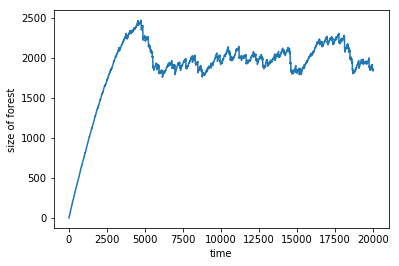

In [5]:
plot_forest(simulate_forest(grid_size=100, t=20000, trials=1, prob=0.80))

We can see the forest self-organizing to a **critical state** of supporting around 2000 trees (+- 500). 

This critical state can be seen even better if you take the average of say 30 runs:

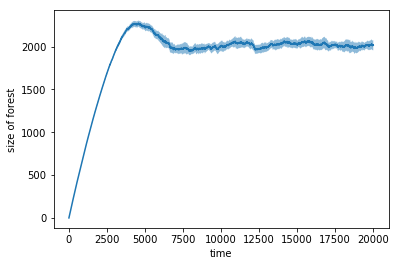

In [6]:
plot_forest(simulate_forest(grid_size=100, t=20000, trials=30, prob=0.80))

Let's look at the distribution of the fire sizes to see if they do follow a power law: 

In [60]:
fire_sizes = get_fire_sizes(simulate_forest(grid_size=100, t=20000, trials=1, prob=0.80, return_population_list=True)[0])

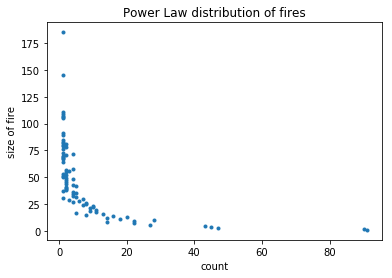

In [53]:
values, labels = zip(*Counter(fire_sizes).items())
indexes = np.arange(len(labels))
width = 1

plt.plot(labels, values,'.')
plt.title('Power Law distribution of fires')
plt.xlabel('count')
plt.ylabel('size of fire')
plt.show()

Yup, looks like it. Note this only holds true near the critical point (which it tends towards to). I've not made the effort to exclude the first 3000 periods or so when the forest is still growing thinking that the far longer time of the forest being near criticality should dominate this pattern enough to look like a power law, which it does. 
<br>
Thus this pattern shouldn't hold at the start (in the first 3000t)

In [56]:
fire_sizes = get_fire_sizes(simulate_forest(grid_size=100, t=20000, trials=1, prob=0.80, return_population_list=True)[0][:3000])

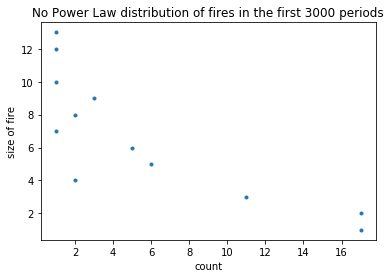

In [58]:
values, labels = zip(*Counter(fire_sizes).items())
indexes = np.arange(len(labels))
width = 1

plt.plot(labels, values,'.')
plt.title('No Power Law distribution of fires in the first 3000 periods')
plt.xlabel('count')
plt.ylabel('size of fire')
plt.show()

Here we don't observe the extreme events and the long-tail common to a power law distribution. Granted, there is not a lot of data, but this finding should nevertheless not come as a surprise. When the forest is still growing there aren't patches of forest dense enough to produce rare large-scale fires

** The hump ** <br>

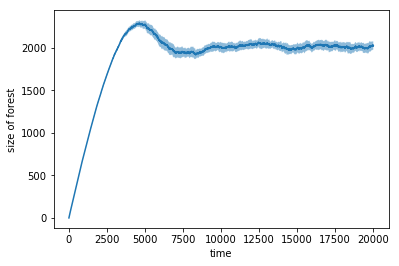

In [66]:
plot_forest(simulate_forest(grid_size=100, t=20000, trials=30, prob=0.80))

Why do we see this initial "hump" of the forest being able to shoot significantly above our level of criticality?

It occurs because of our artificial assumption that trees grow at random location thus in a sparse manner across the grid, but burn in patches.
Growing a *thin* forest keeps fires small and with that increased resistance it is able to temporarily support a larger population of trees. 
As the forest densifies and trees burn in *patches* however, the likelihood of any one lightning hit producing a large-scale fire has increased to the point that the permanent stable critical state lowers down again. 

**Note: the assumption of trees growing so sparsely is of course an artificial one so in the real world there wouldn't be any such hump*

Interestingly, on a smaller grid we see no such hump

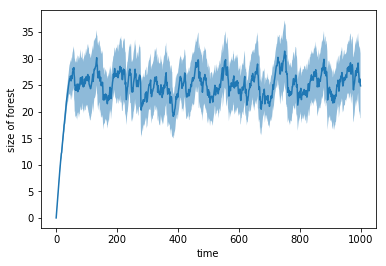

In [67]:
plot_forest(simulate_forest(grid_size=10, t=1000, trials=30, prob=0.80))

**why?**

because the grid is too small to support separate individual *clusters* of forest so each turn almost the whole forest burns down and grows back again:

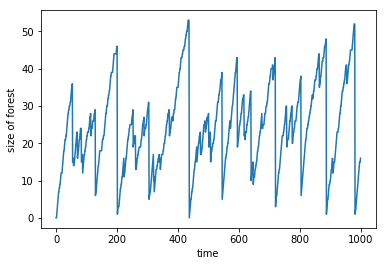

In [64]:
plot_forest(simulate_forest(grid_size=10, t=1000, trials=1, prob=0.80))

## Conclusion
Isn't that cool? <br>
**The critical state is not reached by an adjustment of a parameter, i.e. trees don't learn to adjust how far away from a neighboring tree they should grow**<br>
Instead, the mechanics of the model solely depend on the adjustment of the number and density of trees as a product of two necessary conditions for self-organized criticality. One the gradual increase in pressure (tree-growth), and the sudden decrease in bursts (fires). 
<br>
Variants of this model can help us explain earthquakes, solar flares and traffic jams.
<br> 
<br>
Also looking at this deeper bears some interesting findings such as this:

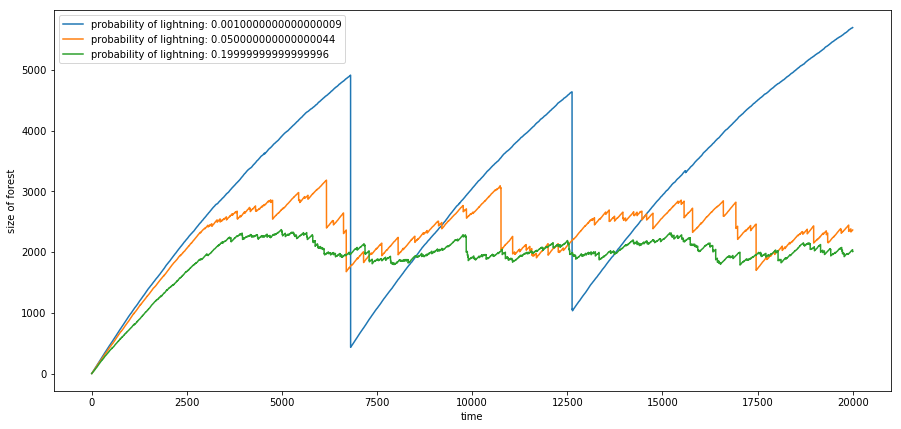

In [70]:
fig= plt.figure(figsize=(15,7))
plot_forest(simulate_forest(grid_size=100, t=20000, trials=1, prob=0.999))
plot_forest(simulate_forest(grid_size=100, t=20000, trials=1, prob=0.95))
plot_forest(simulate_forest(grid_size=100, t=20000, trials=1, prob=0.80))
plt.legend()
plt.show()

We obviously want to avoid forest-fires, but looking at this graph one can also see that in a system where fires are rarer it leads to real catastrophes once lightning does hit. 
Instead, frequent shocks make the system robust by avoiding the build-up of large clusters vulnerable to lightning.
This is of course widely adopted in forestry already: Clustering areas by creating swathes in-between to mitigate the effect of the inevitable fire. And also elsewhere we've learned this lesson, for instance in software engineering. We used to follow a positive engineering frame in which one aims to avoid error and construct a 100% bullet-proof piece of software. Now realizing that errors are inevitable and acting as if they aren't will lead to black-swan system outages we have instead started to embrace negative engineering, in which we write tests and act as if any piece of code can always break as well as silo the architecture to attempt preventing such catastrophes. 
<br>
Yet, recent events such as the global financial crisis 2017 also indicate that globalization and complexity through technology have increasingly led to our whole planet being a "much denser forest" causing rare but potentially devastating fires. 

<br>
This notebook was inspired by <a href="https://www.amazon.com/Model-Thinker-What-Need-Know/dp/0465094627/ref=sr_1_1?keywords=model+thinker&qid=1563988901&s=gateway&sr=8-1">The Model Thinker by Scott Page</a>. It's an excellent book covering a whole myriad of models that could keep me busy exploring them for years to come. I dived deeper into self-organized criticality because I didn't get the intuition behind it at all as well as why it matters. 
<br>

## Appendix: Tuning my burn function

In [72]:
# first attempt, see function code above. Naive implementation with almost trees_to_be_burned^2 big o
grid = create_grid(100, cell=1)
start = time.time()
burn_trees(50,50, grid)
end = time.time()
print('function burn_trees: ',end - start)


# second function. Uses a set (thus unique) queue to find the neighbors. 
grid = create_grid(100, cell=1)
start = time.time()
burn_trees_faster(50,50, grid)
end = time.time()
print('function burn_trees_faster: ',end - start)

# crazy what a difference data structures can make: 

function burn_trees:  11.222636222839355
function burn_trees_faster:  0.050566911697387695
